<a href="https://colab.research.google.com/github/CristianDSJ/Grains/blob/main/N-Grain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cellpose --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 34.8 MB/s eta 0:00:00


In [ ]:
# @title  {"form-width":"20%"}
# @title  {"run":"auto","form-width":"500px"}
device_selection = "Auto"  # @param ["Auto", "CPU", "GPU"]

import os
import numpy as np
import torch
import gdown
from cellpose import models, io, plot
from cellpose.utils import masks_to_outlines
from google.colab import files
from skimage import transform
from skimage.measure import regionprops
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import curve_fit
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, RadioButtons, Checkbox, HBox, VBox, Dropdown, IntSlider, Text
from IPython.display import display

if device_selection == "Auto":
    if torch.cuda.is_available():
        use_gpu = True
        runtime_device = "GPU"
    elif "COLAB_TPU_ADDR" in os.environ:
        use_gpu = True
        runtime_device = "TPU"
    else:
        use_gpu = False
        runtime_device = "CPU"

elif device_selection == "GPU":
    if torch.cuda.is_available():
        use_gpu = True
        runtime_device = "GPU"
    else:
        use_gpu = False
        runtime_device = "CPU (GPU no disponible)"
        print("⚠️ Colab no está conectado a GPU")


else:
    use_gpu = False
    runtime_device = "CPU"

print(f"Dispositivo utilizado: {runtime_device}\n")
print("Descargando modelo...\n")
io.logger_setup()

file_id = "1P86rO2_xTc9oaA54hw-lC0qmBwvjphpC"
url = f"https://drive.google.com/uc?id={file_id}"
output_name = "Trained_model.cpn"

gdown.download(url, output_name, quiet=True)
model = models.CellposeModel(
    gpu=use_gpu,
    pretrained_model=output_name
)

print("\n✔️ Modelo cargado")
print(f"✔️ Usando: {runtime_device}")


Dispositivo utilizado: GPU

Descargando modelo...

creating new log file
2025-11-25 13:12:27,253 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-11-25 13:12:27,253 [INFO] 
cellpose version: 	4.0.7 
platform:       	linux 
python version: 	3.12.12 
torch version:  	2.9.0+cu126
2025-11-25 13:12:34,351 [INFO] ** TORCH CUDA version installed and working. **
2025-11-25 13:12:34,353 [INFO] >>>> using GPU (CUDA)
2025-11-25 13:12:42,024 [INFO] >>>> loading model Trained_model.cpn

✔️ Modelo cargado
✔️ Usando: GPU


Saving Rutenato.tif to Rutenato.tif


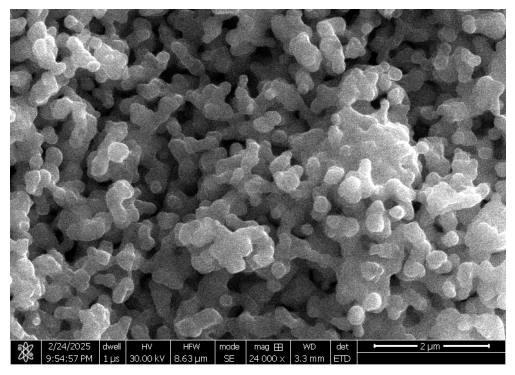

In [ ]:
# @title Subir Imagen
uploaded = files.upload()
image_name = list(uploaded.keys())[0]

img = io.imread(image_name)
h, w = img.shape[:2]

if use_gpu==False:
  h, w = img.shape[:2]
  scale = 224 / max(h, w)
  print("\nUsando CPU: redimensionando la imagen a 224x224 para aumentar velocidad")
  print("Los resultados pueden ser inestables")
else:
  scale=1

new_h, new_w = int(h*scale), int(w*scale)
img_resized = transform.resize(img, (new_h, new_w), anti_aliasing=True, preserve_range=True)
img = img_resized.astype(img.dtype)

plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()

In [ ]:
# @title Obtención de la máscara
umbral_slider = widgets.FloatSlider(
    min=0, max=1, step=0.1, value=0,
    description='Umbral detección',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px'),
    continuous_update=False
)
norma_slider = widgets.FloatSlider(
    min=0, max=1, step=0.1, value=0,
    description='Normalización',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px'),
    continuous_update=False
)
sens_slider = widgets.FloatSlider(
    min=0, max=1, step=0.1, value=1,
    description='Sensibilidad bordes',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px'),
    continuous_update=False
)
status_label = widgets.Label("")
output_plot = widgets.Output()

#Función principal
def procesar_cambios(change=None):
    global masks, flows, styles, outlines
    for s in [umbral_slider, norma_slider, sens_slider]:
        s.disabled = True
    status_label.value = "⏳Procesando la imagen..."

    with output_plot:
        output_plot.clear_output(wait=True)

        # --- Ejecutar modelo ---
        img_selected_channels = img.copy()
        masks, flows, styles = model.eval(
            img_selected_channels,
            batch_size=32,
            flow_threshold=sens_slider.value,
            cellprob_threshold=umbral_slider.value,
            normalize={"tile_norm_blocksize": norma_slider.value}
        )

        outlines = masks_to_outlines(masks)

        # --- Mostrar resultado ---
        plt.figure(figsize=(6,6))
        plt.imshow(img, cmap='gray')
        plt.contour(outlines, colors='black', linewidths=0.8)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Desbloquear sliders
    for s in [umbral_slider, norma_slider, sens_slider]:
        s.disabled = False
    status_label.value = "Bordes detectados:"

# --- Conectar los sliders manualmente ---
for s in [umbral_slider, norma_slider, sens_slider]:
    s.observe(procesar_cambios, names='value')

# --- Mostrar interfaz ---
ui = widgets.VBox([
    umbral_slider, norma_slider, sens_slider, status_label, output_plot
])
display(ui)

# --- Ejecutar una vez al inicio ---
procesar_cambios()

In [ ]:
# @title Control Visualización
variable_name = ""
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#ff7f0e"])

# Verificación de dependencias básicas
props = regionprops(masks)
H, W = masks.shape

DD = None
DD_err = None
diametros_region = None
anchos_region = None
largos_region = None

def gauss(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def mostrar_region(tipo_medida, minr, maxr, minc, maxc,
                   ancho, largo, mostrar_circulos, mostrar_numeros):

    global DD, DD_err, diametros_region

    # Conversión %
    minr_px = int(H * minr / 100)
    maxr_px = int(H * maxr / 100)
    minc_px = int(W * minc / 100)
    maxc_px = int(W * maxc / 100)

    if minr_px >= maxr_px or minc_px >= maxc_px:
        print("⚠️ Región inválida: Top<Bottom y Left<Right.")
        return

    # Filtrar regiones
    props_filtrados = [
        p for p in props
        if p.bbox[0] > minr_px and p.bbox[1] > minc_px and
           p.bbox[2] < maxr_px and p.bbox[3] < maxc_px
    ]

    N = len(props_filtrados)

    # Tipo de medida
    if tipo_medida == 'centroides':
        medidas = np.array([p.equivalent_diameter for p in props_filtrados])
        datos = {'Diámetro': medidas}
        diametros_region = medidas

    else:
        datos = {}
        global anchos_region, largos_region
        if ancho:
            anchos_region = np.array([p.minor_axis_length for p in props_filtrados])
            datos['Ancho'] = anchos_region
        else:
            anchos_region = None

        if largo:
            largos_region = np.array([p.major_axis_length for p in props_filtrados])
            datos['Largo'] = largos_region
        else:
            largos_region = None


        if not datos:
            print("⚠️ Selecciona ancho o largo.")
            return

    # Figura
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.3, 1]}
    )

    ax1.imshow(outlines, cmap='gray')

    rect = plt.Rectangle((minc_px, minr_px), maxc_px-minc_px, maxr_px-minr_px,fill=False, edgecolor='white', linewidth=2)
    ax1.add_patch(rect)

    # Círculos / elipses
    if mostrar_circulos:
        for i, p in enumerate(props_filtrados, start=1):
            y, x = p.centroid
            if tipo_medida == 'centroides':
                r = p.equivalent_diameter / 2
                ax1.add_patch(plt.Circle((x, y), r, color='orange', fill=False, lw=1))
            else:
                y0, x0 = p.centroid
                e = Ellipse((x0, y0), p.minor_axis_length, p.major_axis_length,
                            angle=-p.orientation * 180/np.pi,
                            edgecolor='orange', fill=False, lw=1)
                ax1.add_patch(e)

            if mostrar_numeros:
                ax1.text(x, y, str(i), color='yellow', fontsize=7,
                         ha='center', va='center')

    ax1.set_title(f'{N} objetos en región')
    ax1.axis('off')

    # Histograma
    if N > 0:
        for nombre, medidas in datos.items():
            counts, bins, _ = ax2.hist(medidas, bins=15, edgecolor='white', alpha=0.4, label=nombre)
            centers = (bins[:-1] + bins[1:]) / 2

            try:
                popt, _ = curve_fit(gauss, centers, counts,p0=[np.mean(medidas), np.std(medidas), counts.max()])
                mu, sigma, A = popt
                DD = mu
                DD_err = sigma / np.sqrt(N)
                xfit = np.linspace(min(bins), max(bins), 200)
                ax2.plot(xfit, gauss(xfit, *popt), '--',color="gray", lw=2, label=f'{nombre}: {mu:.2f} ± {DD_err:.2f}')
                ax2.legend()
            except:
                ax2.clear()
                ax2.axis('off')

                DD = medidas.mean()
                DD_err = medidas.std() / np.sqrt(N)

                ax2.text(0.5, 0.5,
                        "⚠️ No es posible realizar el ajuste",
                        ha='center', va='center',
                        color='black', fontsize=10, transform=ax2.transAxes)

    else:
        ax2.text(0.5, 0.5, "Sin objetos", ha='center', va='center')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

tipo_medida = RadioButtons(options=['centroides', 'elipses'], description='Medida')

ancho_chk = Checkbox(value=True, description='Ancho')
largo_chk = Checkbox(value=False, description='Largo')
mostrar_circulos_chk = Checkbox(value=True, description='Círculos/Elipses')
mostrar_numeros_chk = Checkbox(value=False, description='Numerar')

ancho_chk.layout.visibility = "hidden"
largo_chk.layout.visibility = "hidden"

def actualizar_visibilidad(change=None):
    if tipo_medida.value == "elipses":
        ancho_chk.layout.visibility = "visible"
        largo_chk.layout.visibility = "visible"
    else:
        ancho_chk.layout.visibility = "hidden"
        largo_chk.layout.visibility = "hidden"

tipo_medida.observe(actualizar_visibilidad, "value")

# ---- Sliders de región ----
slider_top = FloatSlider(min=0, max=100, value=10, description='Top (%)')
slider_bottom = FloatSlider(min=0, max=100, value=90, description='Bottom (%)')
slider_left = FloatSlider(min=0, max=100, value=10, description='Left (%)')
slider_right = FloatSlider(min=0, max=100, value=90, description='Right (%)')

ui = VBox([
    tipo_medida,
    HBox([ancho_chk, largo_chk]),
    mostrar_circulos_chk,
    mostrar_numeros_chk,
    slider_top,
    slider_bottom,
    slider_left,
    slider_right
])


@interact(
    tipo_medida=tipo_medida,
    minr=slider_top,
    maxr=slider_bottom,
    minc=slider_left,
    maxc=slider_right,
    ancho=ancho_chk,
    largo=largo_chk,
    mostrar_circulos=mostrar_circulos_chk,
    mostrar_numeros=mostrar_numeros_chk,
)
def _(tipo_medida, minr, maxr, minc, maxc, ancho, largo, mostrar_circulos, mostrar_numeros):
    actualizar_visibilidad()
    mostrar_region(tipo_medida, minr, maxr, minc, maxc,
                   ancho, largo, mostrar_circulos, mostrar_numeros)


interactive(children=(RadioButtons(description='Medida', options=('centroides', 'elipses'), value='centroides'…

In [ ]:
# @title Ajuste de de escala
H, W = img.shape[:2]
UU = None
unidad_global = None

@interact(
    x_ini=FloatSlider(min=0, max=W, step=1, value=W*0.80, description='Borde izq.'),
    x_fin=FloatSlider(min=0, max=W, step=1, value=W*0.99, description='Borde der.'),
    y_pos=FloatSlider(min=0, max=H, step=1, value=H*0.95, description='Pos. Vertical'),
    longitud_real=Text(value='5 µm', description='Longitud real')
)
def definir_escala(x_ini, x_fin, y_pos, longitud_real):
    global UU, unidad_global

    partes = longitud_real.strip().split()
    if len(partes) != 2:
        print("⚠️ Ingresa la longitud con su unidad, por ejemplo: '5 µm' o '500 nm'")
        return

    valor = float(partes[0])
    unidad = partes[1].lower()
    unidad_global = unidad

    # --- Convertir todo a micrómetros como base ---
    if unidad in ['µm', 'um']:
        valor_um = valor
    elif unidad == 'nm':
        valor_um = valor / 1000
    elif unidad == 'mm':
        valor_um = valor * 1000
    else:
        print("Unidad no reconocida. Usa nm, µm o mm.")
        return

    # --- Calcular distancia en píxeles ---
    dist_px = abs(x_fin - x_ini)

    # --- Escala (µm/px) ---
    um_por_px = valor_um / dist_px

    # Convertir la escala a la unidad original y guardar en variable global
    if unidad in ['µm', 'um']:
        UU = um_por_px
    elif unidad == 'nm':
        UU = um_por_px * 1000
    elif unidad == 'mm':
        UU = um_por_px / 1000

    # --- FIGURA PRINCIPAL + ZOOM ---
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    # --- Imagen completa ---
    axs[0].imshow(img, cmap='gray')
    axs[0].plot([x_ini, x_fin], [y_pos, y_pos], 'r-', lw=2)
    axs[0].axis('off')

    # --- ZOOM ---
    zoomx = 10  # ancho del recorte alrededor de la barra (ajustable)
    zoomy = 280
    x1 = int(max(0, min(x_ini, x_fin) - zoomx))
    x2 = int(min(W, max(x_ini, x_fin) + zoomx))
    y1 = int(max(0, y_pos - zoomy))
    y2 = int(min(H, y_pos + zoomy))

    recorte = img[y1:y2, x1:x2]

    axs[1].imshow(recorte, cmap='gray')
    axs[1].axis('off')

    # Dibujar barra dentro del zoom ----------------
    axs[1].plot(
        [x_ini - x1, x_fin - x1],
        [y_pos - y1, y_pos - y1],
        'r-', lw=2
    )
    plt.subplots_adjust(wspace=0.02)
    plt.show()
    print(f"\nBarra de escala: {dist_px:.1f} px")
    print(f"1 px = {UU:.5f} {unidad}\n")

interactive(children=(FloatSlider(value=614.4000000000001, description='Borde izq.', max=768.0, step=1.0), Flo…

In [ ]:
# @title Exportar gráfica
fig_actual = None

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 13,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.linewidth': 1.0,
    'lines.linewidth': 1.5,
})

def gauss(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def calcular_bins_fd(data):
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    n = len(data)
    bin_width = 2 * iqr / np.cbrt(n)
    if bin_width == 0:
        return 10
    rango = data.max() - data.min()
    return int(np.ceil(rango / bin_width))

def calcular_bins_sturges(data):
    n = len(data)
    return int(np.ceil(np.log2(n) + 1)) if n > 0 else 1


# =======================================================
# CHECKBOX PERSISTENTE (NO SE RECREA NUNCA)
# =======================================================

exportar_pdf = widgets.Checkbox(
    value=False,
    description="Guardar como PDF",
    indent=False,
    layout=widgets.Layout(width='2000px')
)
exportar_pdf_box = widgets.HBox(
    [exportar_pdf],
    layout=widgets.Layout(width='1000px')
)


def on_exportar_change(change):
    global fig_actual
    if change['new'] is True and fig_actual is not None:
        filename = "histograma_exportado.pdf"
        fig_actual.savefig(filename, dpi=300, bbox_inches='tight')
        files.download(filename)

        # Desactivar temporalmente evento
        exportar_pdf.unobserve(on_exportar_change, 'value')
        exportar_pdf.value = False
        exportar_pdf.observe(on_exportar_change, 'value')

exportar_pdf.observe(on_exportar_change, 'value')


# =======================================================
# WIDGETS NORMALES
# =======================================================

tipo_medida_hist = Dropdown(
    options=["centroide", "elipse"],
    value="centroide",
    description="Tipo de medida:",
    style={'description_width': '150px'},
    layout=widgets.Layout(width='350px')
)

ancho_hist = Checkbox(
    value=True,
    description="Usar ancho",
    layout=widgets.Layout(width='200px', visibility='hidden')
)

largo_hist = Checkbox(
    value=False,
    description="Usar largo",
    layout=widgets.Layout(width='200px', visibility='hidden')
)

def actualizar_visibilidad_hist(change=None):
    if tipo_medida_hist.value == "elipse":
        ancho_hist.layout.visibility = "visible"
        largo_hist.layout.visibility = "visible"
    else:
        ancho_hist.layout.visibility = "hidden"
        largo_hist.layout.visibility = "hidden"

tipo_medida_hist.observe(actualizar_visibilidad_hist, "value")
actualizar_visibilidad_hist()


# =======================================================
# FUNCIÓN PRINCIPAL DEL HISTOGRAMA
# =======================================================

@interact(
    tipo_medida=tipo_medida_hist,
    usar_ancho=ancho_hist,
    usar_largo=largo_hist,
    bin_method=Dropdown(
        options=["Sturges", "Manual"],
        value="Sturges",
        description="Método de bins:",
        style={'description_width': '180px'},
        layout=widgets.Layout(width='500px')
    ),
    manual_bins=IntSlider(min=5, max=100, step=1, value=15,
                          description="Bins manuales",
                          style={'description_width': '180px'},
                          layout=widgets.Layout(width='500px')),
    show_fit=Checkbox(value=True, description='Ajuste Gaussiano'),
    titulo=Text(value='Distribución de tamaño', description='Título gráfico')
)
def plot_histograma(tipo_medida, usar_ancho, usar_largo,
                    bin_method, manual_bins, show_fit,
                    titulo):

    plt.close("all")   # Evitar <Figure size ...>

    global fig_actual, DD, DD_err

    unidad_txt = unidad_global if 'unidad_global' in globals() else 'µm'

    # --- Selección de datos ---
    if tipo_medida == "centroide":
        if 'diametros_region' not in globals() or diametros_region is None:
            print("⚠️ No hay diámetros de centroides disponibles.")
            return

        data_base = np.array(diametros_region, dtype=float)
        etiqueta = f"Diámetro ({unidad_txt})"

    else:
        if usar_ancho and 'anchos_region' in globals() and anchos_region is not None:
            data_base = np.array(anchos_region, dtype=float)
            etiqueta = f"Ancho ({unidad_txt})"

        elif usar_largo and 'largos_region' in globals() and largos_region is not None:
            data_base = np.array(largos_region, dtype=float)
            etiqueta = f"Largo ({unidad_txt})"

        else:
            print("⚠️ No hay datos válidos de ancho o largo.")
            return

    # Conversión
    diametros_conv = data_base * UU
    diametros_conv = diametros_conv[~np.isnan(diametros_conv)]
    N = len(diametros_conv)
    if N == 0:
        print("⚠️ No hay datos numéricos válidos.")
        return

    # Bins
    bins = calcular_bins_sturges(diametros_conv) if bin_method == "Sturges" else manual_bins

    # Figura
    fig, ax = plt.subplots(figsize=(7, 5))
    counts, bins_edges, _ = ax.hist(
        diametros_conv,
        bins=bins,
        color='#FFD17D',
        edgecolor='#121212',
        alpha=1.0,
        linewidth=0.3
    )

    bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2

    # Ajuste gaussiano
    if show_fit and N > 0:
        try:
            popt, _ = curve_fit(
                gauss, bin_centers, counts,
                p0=[np.mean(diametros_conv), np.std(diametros_conv), max(counts)]
            )

            mu_fit, sigma_fit, A_fit = popt
            DD = mu_fit
            DD_err = sigma_fit / np.sqrt(N)

            x_fit = np.linspace(bins_edges.min(), bins_edges.max(), 300)
            ax.plot(x_fit, gauss(x_fit, *popt), '--', lw=2,
                    label=f'μ = {DD:.3f} ± {DD_err:.3f} {unidad_txt}\nσ = {sigma_fit:.3f} {unidad_txt}')
            ax.legend(frameon=False)

        except Exception as e:
            print("⚠️ Error en ajuste:", e)

    # Etiquetas
    ax.set_xlabel(etiqueta)
    ax.set_ylabel("Frecuencia")
    ax.set_title(titulo)

    # Mostrar checkbox debajo del título
    display(exportar_pdf_box)

    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    # Guardar figura actual
    fig_actual = fig

    plt.show()


interactive(children=(Dropdown(description='Tipo de medida:', layout=Layout(width='350px'), options=('centroid…